In [31]:
import math as math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.preprocessing import StandardScaler, Normalizer, KBinsDiscretizer, FunctionTransformer, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [32]:
data_cols = ["RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe"]
target_col = "class"
col_names = ["id", *data_cols, target_col]

file_path = "../data/glass.data"
dataset = pd.read_csv(file_path, names=col_names)

# Exploration

In [33]:
dataset.shape

(214, 11)

In [34]:
dataset.head(10)

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [35]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      214 non-null    int64  
 1   RI      214 non-null    float64
 2   Na      214 non-null    float64
 3   Mg      214 non-null    float64
 4   Al      214 non-null    float64
 5   Si      214 non-null    float64
 6   K       214 non-null    float64
 7   Ca      214 non-null    float64
 8   Ba      214 non-null    float64
 9   Fe      214 non-null    float64
 10  class   214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


In [36]:
dataset.describe()

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,107.500000,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,61.920648,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.000000,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,54.250000,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,107.500000,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,160.750000,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,214.000000,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [37]:
dataset[target_col].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: class, dtype: int64

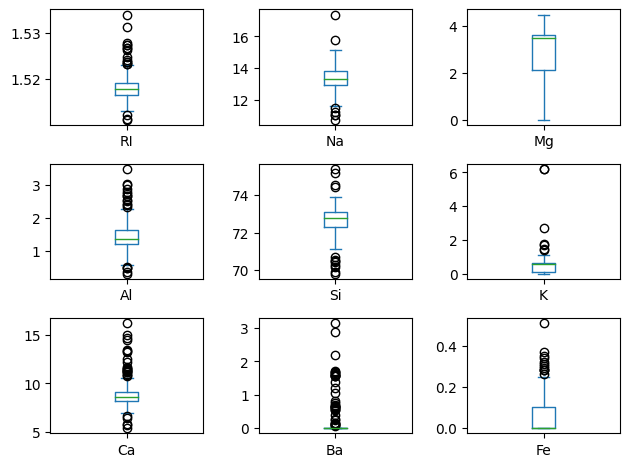

In [38]:
dataset[data_cols].plot(kind="box", subplots=True, layout=(3, 3), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

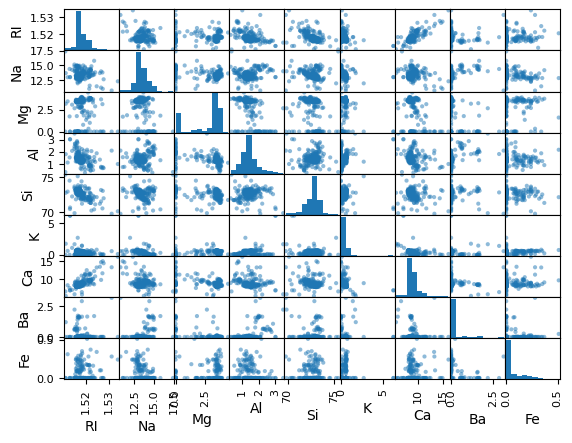

In [39]:
pd.plotting.scatter_matrix(dataset[data_cols])
plt.show()

<Axes: >

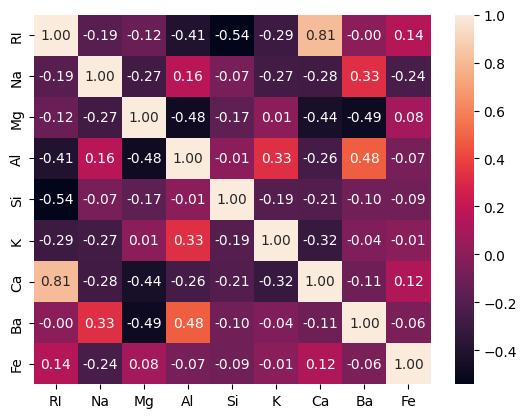

In [40]:
sns.heatmap(dataset[data_cols].corr(), annot=True, fmt=".2f")

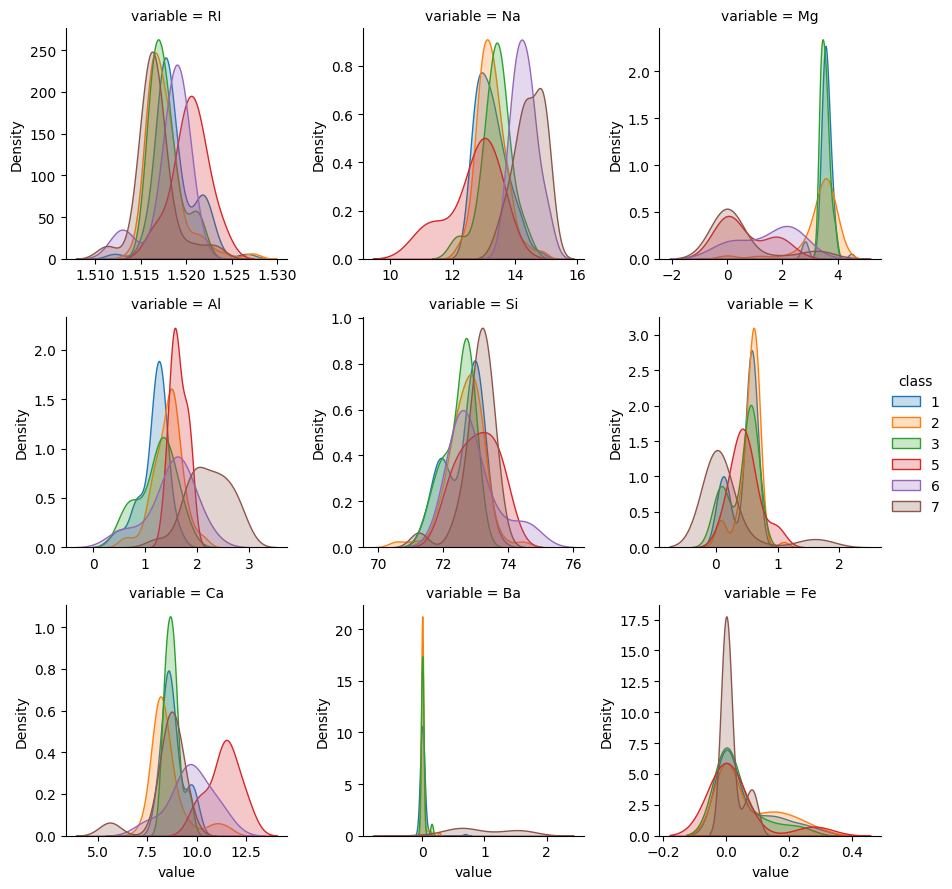

In [41]:
melted = dataset[(np.abs(stats.zscore(dataset)) < 3).all(axis=1)]
melted = pd.melt(melted, target_col, data_cols)
sns.FacetGrid(
    melted,
    col="variable", hue=target_col, col_wrap=3,
    sharex=False, sharey=False
).map(sns.kdeplot, "value", fill=True, warn_singular=False).add_legend()

# Preprocessing

In [42]:
rng = np.random.RandomState(1)

In [43]:
X_full = dataset[data_cols]
Y = dataset[target_col]

In [44]:
missing_ratio = 0.05
X = X_full.mask(rng.random(X_full.shape) < missing_ratio)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      199 non-null    float64
 1   Na      208 non-null    float64
 2   Mg      196 non-null    float64
 3   Al      201 non-null    float64
 4   Si      207 non-null    float64
 5   K       197 non-null    float64
 6   Ca      204 non-null    float64
 7   Ba      204 non-null    float64
 8   Fe      207 non-null    float64
dtypes: float64(9)
memory usage: 15.2 KB


In [45]:
test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, stratify=Y, random_state=rng)

Y_test.value_counts()

2    23
1    21
7     9
3     5
5     4
6     3
Name: class, dtype: int64

In [46]:
imputers = {
    "KNN-1": KNNImputer(n_neighbors=1),
    "KNN-3": KNNImputer(n_neighbors=3),
    "MEAN": SimpleImputer(strategy="mean"),
    "MEDIAN": SimpleImputer(strategy="median")
}

In [47]:
transformers = {
    "PASSTHROUGH": "passthrough",
    "SCALE": StandardScaler(),
    "NORMALIZE": Normalizer(),
    "DISCRETIZE-3": KBinsDiscretizer(n_bins=3, encode="onehot-dense"),
    "VAR-THRESHOLD-0.5": VarianceThreshold(threshold=0.5),
    "SELECT-3-BEST": SelectKBest(k=3),
    "PCA": PCA(random_state=rng),
    "ROBUST": RobustScaler(),
    "POWER": PowerTransformer(),
    "QUANTILE-UNIFORM": QuantileTransformer(n_quantiles=50, output_distribution="uniform", random_state=rng),
    "QUANTILE-NORMAL": QuantileTransformer(n_quantiles=50, output_distribution="normal", random_state=rng)
}

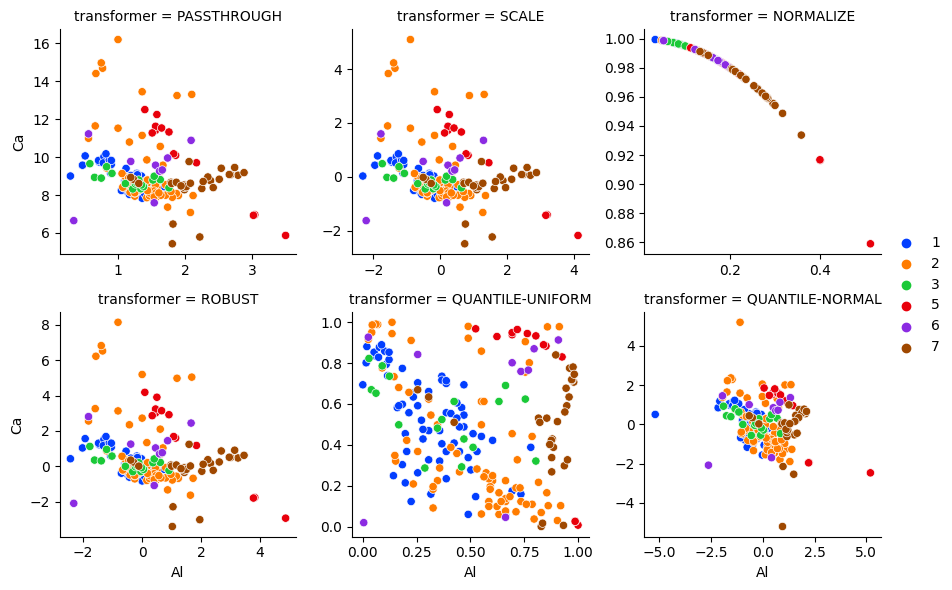

In [48]:
sns.FacetGrid(
    pd.concat(
        pd.DataFrame(
            make_pipeline(transformers[n])
                .fit_transform(dataset[["Al", "Ca"]].to_numpy(), dataset[target_col]),
            columns=["Al", "Ca"]
        ).assign(**{"transformer": n, "class": dataset[target_col]})
        for n in ["PASSTHROUGH", "SCALE", "NORMALIZE", "ROBUST", "QUANTILE-UNIFORM", "QUANTILE-NORMAL"]
    ), col="transformer", col_wrap=3, sharex=False, sharey=False
).map_dataframe(sns.scatterplot, x="Al", y="Ca", hue="class", palette="bright").add_legend()

# Classification

In [49]:
classifiers = {
    "NAIVE-BAYES-1e-9": GaussianNB(var_smoothing=1e-9),
    "NAIVE-BAYES-1e-6": GaussianNB(var_smoothing=1e-6),
    "NAIVE-BAYES-1e-3": GaussianNB(var_smoothing=1e-3),
    "DECISION-TREE-2-GINI": DecisionTreeClassifier(max_depth=2, criterion="gini", random_state=rng),
    "DECISION-TREE-10-GINI": DecisionTreeClassifier(max_depth=10, criterion="gini", random_state=rng),
    "DECISION-TREE-2-ENTROPY": DecisionTreeClassifier(max_depth=2, criterion="entropy", random_state=rng),
    "DECISION-TREE-10-ENTROPY": DecisionTreeClassifier(max_depth=10, criterion="entropy", random_state=rng),
    "KNN-3": KNeighborsClassifier(n_neighbors=3),
    "SVC-LINEAR": LinearSVC(random_state=rng),
    "SVC-RBF": SVC(gamma="auto", random_state=rng),
    "RANDOM-FOREST": RandomForestClassifier(random_state=rng)
}

In [50]:
search_pipeline = Pipeline([
    ("imputer", "passthrough"),
    ("transformer", "passthrough"),
    ("classifier", next(iter(classifiers.values())))
])

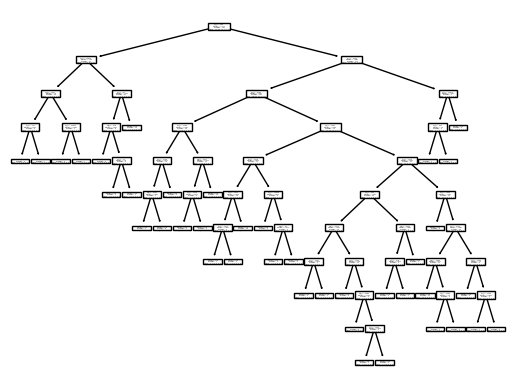

In [51]:
tree_classifier = make_pipeline(imputers["MEAN"], classifiers["DECISION-TREE-10-ENTROPY"])
tree_classifier.fit(X_train, Y_train)
plot_tree(tree_classifier.named_steps["decisiontreeclassifier"])
plt.show()

# Metrics

In [52]:
grid_search = GridSearchCV(search_pipeline, {
    "imputer": list(imputers.values()),
    "transformer": list(transformers.values()),
    "classifier": list(classifiers.values())
}, n_jobs=-1)

grid_search.fit(X_train, Y_train)

print(grid_search.best_score_)
best_pipeline = grid_search.best_estimator_
best_pipeline

0.7514942528735632


Pipeline(steps=[('imputer', KNNImputer(n_neighbors=1)),
                ('transformer',
                 QuantileTransformer(n_quantiles=50,
                                     random_state=RandomState(MT19937) at 0x17C493FC240)),
                ('classifier',
                 RandomForestClassifier(random_state=RandomState(MT19937) at 0x17C493FF940))])

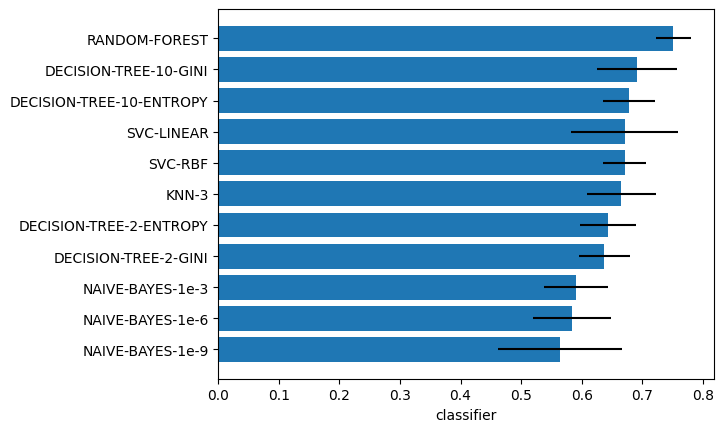

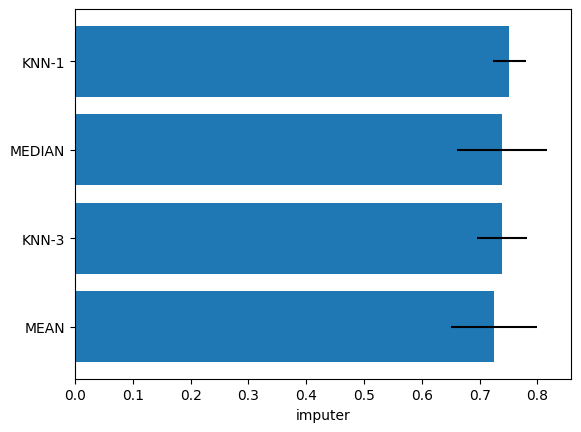

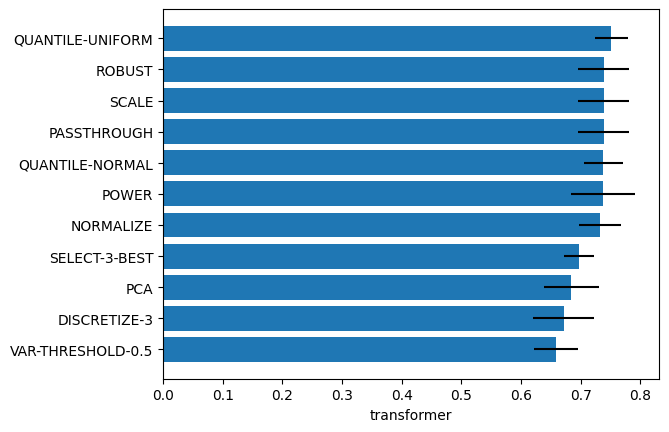

In [62]:
def lookup(what, where):
    match where:
        case "imputer":
            d = imputers
        case "transformer":
            d = transformers
        case "classifier":
            d = classifiers
    return next(k for k in d if d[k] == what)

res = grid_search.cv_results_
for i, p in enumerate(grid_search.best_params_.keys()):
    x, y, std = zip(*sorted([
        max([
            (lookup(param, p), entry[1], entry[2])
            for entry in zip(res["params"], res["mean_test_score"], res["std_test_score"])
            if entry[0][p] == param
        ], key=lambda x: x[1])
        for param in grid_search.param_grid[p]
    ], key=lambda x: x[1]))

    ax = plt.axes()
    ax.barh(x, y, xerr=std)
    ax.set_xlabel(p)
    plt.show()

# Final test

In [54]:
final_grid = GridSearchCV(
    make_pipeline(
        KNNImputer(n_neighbors=1),
        QuantileTransformer(random_state=rng),
        RandomForestClassifier(random_state=rng)
    ),
    {
        "quantiletransformer__n_quantiles": np.arange(1, 50, 5),
        "randomforestclassifier__n_estimators": np.arange(1, 150, 5)
    },
    n_jobs=-1
)

final_grid.fit(X_train, Y_train)
print(final_grid.best_score_)
final_estimator = final_grid.best_estimator_
final_estimator

0.7655172413793103


Pipeline(steps=[('knnimputer', KNNImputer(n_neighbors=1)),
                ('quantiletransformer',
                 QuantileTransformer(n_quantiles=41,
                                     random_state=RandomState(MT19937) at 0x17C493FCC40)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_estimators=146,
                                        random_state=RandomState(MT19937) at 0x17C493FC940))])

<Axes: xlabel='n_estimators', ylabel='score'>

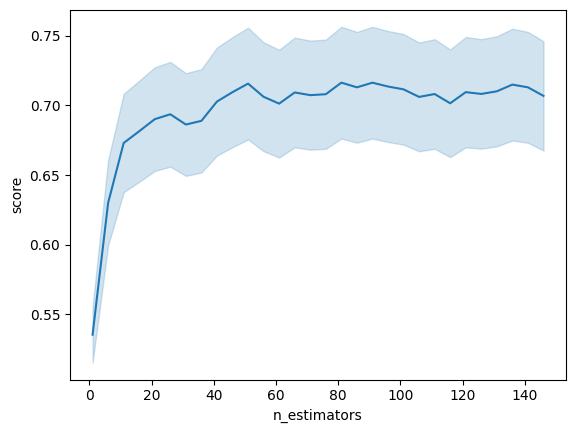

In [55]:
sns.lineplot(data=pd.DataFrame({
    "n_estimators": final_grid.cv_results_["param_randomforestclassifier__n_estimators"],
    "score": final_grid.cv_results_["mean_test_score"]
}), x="n_estimators", y="score", errorbar="se")

<Axes: xlabel='n_quantiles', ylabel='score'>

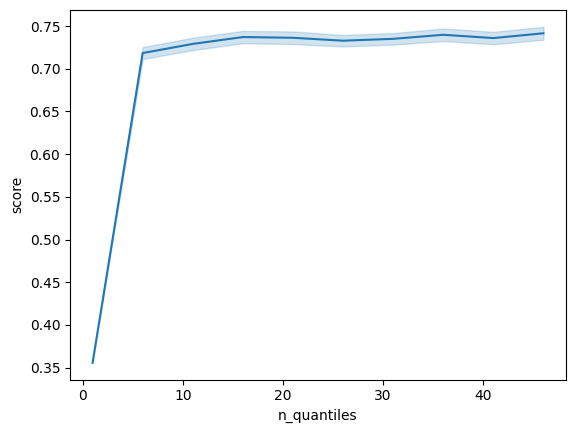

In [56]:
sns.lineplot(data=pd.DataFrame({
    "n_quantiles": final_grid.cv_results_["param_quantiletransformer__n_quantiles"],
    "score": final_grid.cv_results_["mean_test_score"]
}), x="n_quantiles", y="score", errorbar="se")

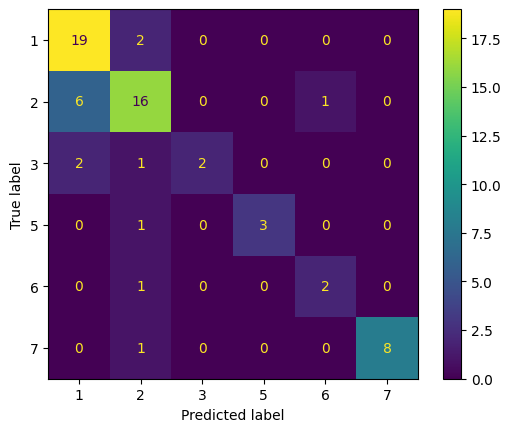

0.7692307692307693
              precision    recall  f1-score   support

           1       0.70      0.90      0.79        21
           2       0.73      0.70      0.71        23
           3       1.00      0.40      0.57         5
           5       1.00      0.75      0.86         4
           6       0.67      0.67      0.67         3
           7       1.00      0.89      0.94         9

    accuracy                           0.77        65
   macro avg       0.85      0.72      0.76        65
weighted avg       0.79      0.77      0.77        65



In [57]:
final_estimator.fit(X_train, Y_train)
predictions = final_estimator.predict(X_test)
ConfusionMatrixDisplay.from_predictions(Y_test, predictions)
plt.show()
print(accuracy_score(Y_test, predictions))
print(classification_report(Y_test, predictions))

### Data without missing values

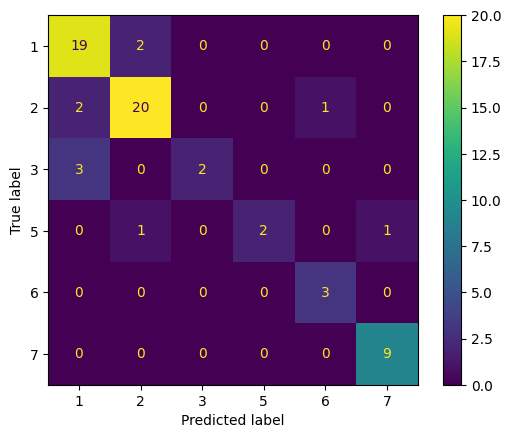

0.8461538461538461
              precision    recall  f1-score   support

           1       0.79      0.90      0.84        21
           2       0.87      0.87      0.87        23
           3       1.00      0.40      0.57         5
           5       1.00      0.50      0.67         4
           6       0.75      1.00      0.86         3
           7       0.90      1.00      0.95         9

    accuracy                           0.85        65
   macro avg       0.89      0.78      0.79        65
weighted avg       0.86      0.85      0.84        65



In [58]:
Xf_train, Xf_test, Yf_train, Yf_test = train_test_split(X_full, Y, test_size=test_size, stratify=Y, random_state=rng)

final_estimator.fit(Xf_train, Yf_train)
predictions = final_estimator.predict(Xf_test)
ConfusionMatrixDisplay.from_predictions(Yf_test, predictions)
plt.show()
print(accuracy_score(Yf_test, predictions))
print(classification_report(Yf_test, predictions))